## 3.5 新聞分類：多分類問題 (路透社數據集)
本結使用**路透社數據集**，它包含許多短新聞以及主題豐富的專題報討。它包含46個不同的主題：而餵進本資料集的樣本，每個主題至少有10個樣本。


In [9]:
# 3-12 加載路透社數據集
!pip install tf-nightly

from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    
    num_words=10000)

###
# 與IMDB數據集一樣，參數num_words=1，
# 將數據限定為前10000個最常出現的單詞，
# 而我們有8982個訓練樣本合2246個測試樣本。
###

print(train_data[10])


  Stored in directory: C:\Users\Camel\AppData\Local\pip\Cache\wheels\89\67\41\63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\Camel\\Anaconda3\\envs\\keras\\Lib\\site-packages\\tensorflow\\python\\_pywrap_tensorflow_internal.pyd'
Consider using the `--user` option or check the permissions.



TypeError: <lambda>() got multiple values for keyword argument 'allow_pickle'

In [1]:
# 3-13 將訓練數據索引[0]解碼為新聞文本

word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in
    train_data[0]])
       

###
# 注意，訓練數據[0]索引值減去了3，因為0、1、2
# 分別為'padding'(填充)、'start of sequence'(序列開始)、
# 'unknown'(未知詞)，所分別保留的索引
###

# 樣本對應的標籤是一個0-45範圍內的整數，亦即，話題索引編號。

print(train_labels[9])


NameError: name 'reuters' is not defined

In [3]:
# 3-14 準備數據(編碼數據)
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)   # 將訓練數據向量化
x_test = vectorize_sequences(test_data)     # 將測試數據向量化


In [5]:
import numpy as np
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

### 另外一種向量化方法 ###
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)     # keras內置，將訓練標籤向量化的方法
one_hot_test_labels = to_categorical(test_labels)



### 3.5.3 構建網路
與前例類似，都是試圖對簡短的文本片段進行分類，但這個問題有一個新的約束條件：輸出類別的數量從2個變成46個。輸出空間的維度要大得多。<br><br>

而前面用過的Dense層的堆疊，每層只能訪問上一層所輸出的訊息，因此，每一層都可能成為訊息瓶頸。上個例子使用了16維的中間層，但對這個例子來說，16維度的空間可能太小了，無法學會區分46個不同的類別。出於這個原因，下面使用維度更大的層，包含64個單元。


In [6]:
# 3-15 模型定義
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))


### 解說
關於這個架構還應該注意另外兩點：<br>
* 網路的最後一層是大小為46的Dense層，這意味著，對於每個輸入樣本，網路都會輸出一個46維度的張量，每個維度代表一個輸出類別。
* 最後一層使用了softmax繳活，輸出值為一個樣本在46個不同的主題的機率，單一樣本於46個主題之機率加總為1。<br><br>

對於這個例子，最好的損失函數是categorical_crossentropy(分類交叉熵)。用於衡量兩個機率分布之間的距離。


In [7]:
# 3-16 編譯模型
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


### 3.5.4 驗證我們的方法
我們要在訓練數據中切割出1000個樣本作為驗證集。


In [8]:
# 3-17 切割出驗證集
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]


In [9]:
# 3-18 訓練模型
# 現在開始訓練網路，共20個輪次

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))


Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 267us/step - loss: 2.5241 - acc: 0.4977 - val_loss: 1.7183 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 2s 209us/step - loss: 1.4443 - acc: 0.6889 - val_loss: 1.3496 - val_acc: 0.7090
Epoch 3/20
7982/7982 [==============================] - 2s 219us/step - loss: 1.0993 - acc: 0.7641 - val_loss: 1.1745 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 2s 207us/step - loss: 0.8729 - acc: 0.8157 - val_loss: 1.0842 - val_acc: 0.7580
Epoch 5/20
7982/7982 [==============================] - 2s 208us/step - loss: 0.7061 - acc: 0.8492 - val_loss: 0.9869 - val_acc: 0.7830
Epoch 6/20
7982/7982 [==============================] - 2s 213us/step - loss: 0.5696 - acc: 0.8790 - val_loss: 0.9418 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 2s 213us/step - loss: 0.4626 - acc: 0.9034 - val_loss: 0.9092 - val_acc: 0.8030


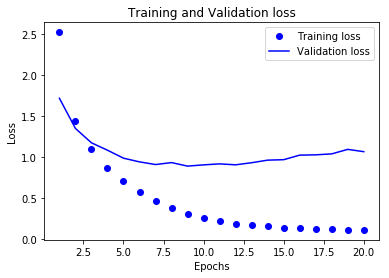

In [12]:
# 3-19 繪製訓練損失和驗證損失

import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) +1 )

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


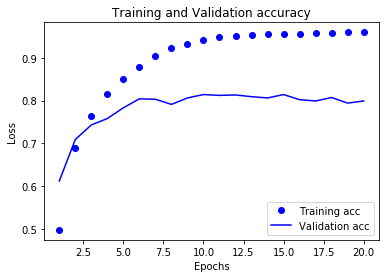

In [16]:
# 3-20 繪製訓練準確度與驗證準確度
plt.clf()   # 清空圖像

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [20]:
# 3-21 從頭到尾重新訓練一個模型
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

print(results)

###
# 這種方法可以得到約80%的準確度
###


Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 2s 257us/step - loss: 3.1744 - acc: 0.4163 - val_loss: 2.3190 - val_acc: 0.5460
Epoch 2/9
7982/7982 [==============================] - 2s 198us/step - loss: 1.8201 - acc: 0.6318 - val_loss: 1.5497 - val_acc: 0.6570
Epoch 3/9
7982/7982 [==============================] - 2s 195us/step - loss: 1.2920 - acc: 0.7319 - val_loss: 1.2605 - val_acc: 0.7260
Epoch 4/9
7982/7982 [==============================] - 2s 199us/step - loss: 0.9973 - acc: 0.7886 - val_loss: 1.1126 - val_acc: 0.7690
Epoch 5/9
7982/7982 [==============================] - 2s 198us/step - loss: 0.7841 - acc: 0.8314 - val_loss: 1.0261 - val_acc: 0.7900
Epoch 6/9
7982/7982 [==============================] - 2s 197us/step - loss: 0.6126 - acc: 0.8726 - val_loss: 0.9530 - val_acc: 0.8000
Epoch 7/9
7982/7982 [==============================] - 2s 204us/step - loss: 0.4773 - acc: 0.8996 - val_loss: 0.9169 - val_acc: 0.8140
Epoch 8

In [23]:
# 一般由完全隨機的分類器能夠得到50%的準確度
# 此例子完全隨機的準確度只能達到約19%

import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)

print(float(np.sum(hits_array)) / len(test_labels))


0.18165627782724844


### 3.5.5 在新數據上生成預測結果
我們可以驗證，模型實例的predict方法返回了在46個主題上的機率分布。現在，我們對所有測試數據生成主題預測。


In [31]:
# 3-22 新數據生成預測結果
import numpy as np
predictions = model.predict(x_test)
print(predictions[777].shape)       # prediction 中的每個元素都是長度為46的向量
print(np.sum(predictions[0]))       # 這個向量的所有元素加總為1
print(np.argmax(predictions[0]))    # 其中，機率最大的類別意味著預測類別


(46,)
1.0000001
3


### 3.5.6 處理標籤和損失的另一種方法
前面提到了另一種編碼標籤的方法，就是將其轉換為整數張量，如下所示：<br>
y_train = np.array(train_labels)<br>
y_test = np.array(test_labels)<br>

對於這種編碼方法，為一需要改變的是損失函數的選擇，於3-21中，one_hot使用的損失函數categorical_crossentropy，標籤應該遵循分類編碼，對於整數標籤，應該使用sparse_categorical_crossentropy，如下。


In [ ]:
# 這個損失函數在數學上
# 與categorical_crossentropy完全相同
# 兩者只是接口不同

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])


### 3.5.7 中間層維度足夠大的重要性(訊息瓶頸)
前面提到，最終輸出是46維度的，因此中間層的隱藏單元數目不應該小於46太多。現在來看一下，如果中間層的維度遠遠小於46，造成了訊息瓶頸，會發生甚麼有趣的事情。


In [36]:
# 3-23 具有訊息瓶頸的模型
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(2568, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          batch_size=512,
          epochs=10,
          validation_data=(x_val, y_val))
'''
現在網路的驗證準確度約為67%，
比起前面下降了許多，原因在於，
我們試圖將大量訊息(這些訊息足夠恢復46個類別的分割超平面)
壓縮到維度很小的中間空間
網路能夠將大部分必要的訊息塞入這個4維度的隱藏層中，
但並不是全部的訊息。
'''


Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 5s 606us/step - loss: 2.4841 - acc: 0.4192 - val_loss: 1.5940 - val_acc: 0.5980
Epoch 2/10
7982/7982 [==============================] - 4s 503us/step - loss: 1.3906 - acc: 0.6472 - val_loss: 1.3572 - val_acc: 0.6710
Epoch 3/10
7982/7982 [==============================] - 4s 483us/step - loss: 1.1243 - acc: 0.7060 - val_loss: 1.2427 - val_acc: 0.7030
Epoch 4/10
7982/7982 [==============================] - 4s 510us/step - loss: 0.9118 - acc: 0.7526 - val_loss: 1.3394 - val_acc: 0.6900
Epoch 5/10
7982/7982 [==============================] - 4s 513us/step - loss: 0.7554 - acc: 0.7958 - val_loss: 1.1757 - val_acc: 0.7400
Epoch 6/10
7982/7982 [==============================] - 4s 499us/step - loss: 0.5947 - acc: 0.8354 - val_loss: 1.1048 - val_acc: 0.7500
Epoch 7/10
7982/7982 [==============================] - 4s 527us/step - loss: 0.4953 - acc: 0.8567 - val_loss: 1.2297 - val_acc: 0.7450


'\n現在網路的驗證準確度約為67%，\n比起前面下降了許多，原因在於，\n我們試圖將大量訊息(這些訊息足夠恢復46個類別的分割超平面)\n壓縮到維度很小的中間空間\n網路能夠將大部分必要的訊息塞入這個4維度的隱藏層中，\n但並不是全部的訊息。\n'

### 3.5.8 進一步的實驗
* 嘗試使用更多或更少的隱藏單元，比如32個、128個
* 前面使用了兩個隱藏層，現在嘗試使用一個或三個隱藏層


### 3.5.9 小結
下面是我們應該從這個例子中學到的重點：
* 如果要對N個類別的數據點進行分類，網路的最後一層應該是大小為N的Dense層。
* 若多個數據點能夠劃分到一個類別，此問題就屬於單標籤、多分類問題；若每個數據點可以分到多個類別，則該問題屬於多標籤、多類別。
* 對於單標籤、多分類問題，網路的最後一層應該使用softmax繳活，這樣可以輸出在N個輸出類別上的機率分佈。
* 這種問題的損失函數幾乎總是應該使用分類交叉熵(categorical_crossentropy)，他將網路輸出的機率分布與目標的真實分布之間的距離最小化。
* 處理多分類問題的標籤有兩種方法：<br>
&nbsp;&nbsp; * 通過分類編碼，(one_hot編碼)須對標籤進行編碼，然後使用categorical_crossentropy作為損失函數。<br>
&nbsp;&nbsp; * 將標籤編碼為整數張量(整數編碼)，然後使用spares_categorical_crossentropy損失函數。
* 如果我們需要將數據劃分到許多類別中，應該避免使用太小的中間層，以免在網路中造成訊息瓶頸。